# Earthquake Occurrence Statistics

The statistics of earthquake occurrence is revealed from catalogs of seismicity, which include event time, location and magnitude. We will talk about how earthquakes are located and how magnitudes are estimated separately, but for now it is sufficient to know that this information can be easily acquired. With such catalogs it is possible to compare the seismic activity of different regions, make informed assessments about the frequency of earthquake occurrence, and learn about the fault rupture process. Maps of the earthquakes in catalogs over time reveal the structure of faulting in a region, and provide a framework with which to study the seismotectonics of a region.

There are two primary earthquake statistics used by seismologists. They are the Gutenberg-Richter relationship (Gutenberg and Richter, 1949), and the Omori Law (Omori, 1894). 

Gutenberg and Richter found that when the logarithm of the number of earthquakes is plotted vs. magnitude that the distribution (data) may be described by the line (model), log(N)=A+Bm, where N is the number of earthquakes, m is the magnitude and A (y-intercept) and B (slope) are refered to as the Gutenberg-Richter statistics or coefficients. They found that on a global scale, and subsequently more generally, the B-value or the slope of the Gutenberg-Richter line is approximately equal to -1. Thus for each increase in earthquake magnitude there are approximately 10 times fewer earthquakes. If, for example, there are 100 M3 events in a region per year, then the Gutenberg-Richter relationship generally finds that there would be approximately 10 M4 events and 1 M5 event in each year. For magnitudes larger than M5 there would be fewer than one event per year. Gutenberg-Richter is a very important earthquake statistic because it is used to determine the rates of earthquake occurrence, which is a key step in characterizing earthquake hazards (we will see this in future homework exercises). 

The Omori Law is used to characterize the rate at which aftershocks occur following a large mainshock event. This statistic is used for comparing the aftershock productivity of different earthquakes and regions, make forecasts of the likelihood of large damaging aftershocks and to distinguish between earthquake faulting and possibly geothermal or volcanic-related seismicity by examining whether the distribution describes a "mainshock/aftershock" pattern or is more "swarm-like". 

In this homework you will use python code in this notebook to investigate the Gutenberg-Richter and Omori statistics for the San Francisco Bay Area, as well as develop numerical analysis skills using python. 

Note: This is not a python class, but the primary programming tool that will be used is python. However, if you know MatLab or have other programing background and would prefer to use it, you are free to use those tools instead. It will be helpful to read sections 9.6 and 9.8 of Lay and Wallace (1995) prior to working on this laboratory for background on the Gutenberg-Richter relation and the Omori Law.

In [3]:
#Initial Setup and Subroutine Definitions
import math
import datetime
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

#This function computes the spherical earth distance between two geographic points and is used in the
#declustering algorithm below
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    
    The first pair can be singular and the second an array

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371.0 * c
    return km

### The Catalog
We have downloaded the Advanced National Seismic System (ANSS) catalog from 1900 to 2018 for you to use (also available here: http://www.quake.geo.berkeley.edu/anss/catalog-search.html), and saved it as a text-file named "anss_catalog_1900to2018all.txt". This catalog has all events in the aforementioned time range located within 100 km of UC Berkeley. Columns of this catalog include information about the catalogued earthquakes, including the date and time of each event, its location in latitude, longitude and depth, and the event magnitude.  

The following python code reads this catalog file and places the information in arrays for analysis.

In [245]:
#Read data and create data arrays

# This catalog is a M0+ search centered at Berkeley radius=100. 
# big enough to include Loma Prieta but exclude Geysers
data=pd.read_csv('anss_catalog_1900to2018all.txt', sep=' ', delimiter=None, header=None)

d=np.array(data)         # load the dataframe into numpy as an array      
year=d[:,0].astype(int)  # define variables from the array
month=d[:,1].astype(int)
day=d[:,2].astype(int)
hour=d[:,3].astype(int)
mn=d[:,4].astype(int)
sec=d[:,5].astype(int)
lat=d[:,6]
lon=d[:,7]
mag=d[:,8]

# Exercise 1: Explore the raw catalog

### Plot the catalog time series
Make an x-y plot showing the magnitude of the earthquake on the y-axis and the time of the event on the x-axis. For this it is useful to determine the days since the beginning of the catalog. The plot will show that the catalog is not uniform due to the fact that over time as more seismic recording stations were installed more earthquakes could be detected and properly located.

In [272]:
# Determine the number of days from the first event
nevt=len(year)
print(f'Number={nevt:d} MinMag={min(mag):.2f} MaxMag={max(mag):.2f}')

Number=69804 MinMag=0.00 MaxMag=6.90


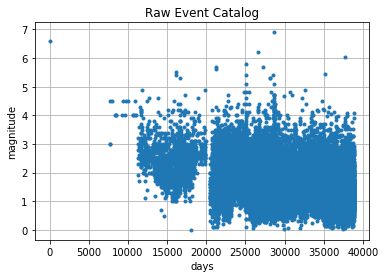

In [273]:
#Plot magnitude vs. time
days=np.zeros(nevt)
for i in range(0,nevt,1):
    d0 = datetime.date(year[0], month[0], day[0])
    d1 = datetime.date(year[i], month[i], day[i])
    delta = d1 - d0
    days[i]=delta.days
    
fig, ax = plt.subplots()
ax.plot(days, mag,'.')
ax.set(xlabel='days', ylabel='magnitude',
       title='Raw Event Catalog')
ax.grid()
fig.savefig("hw1_ex1_fig1.png")
plt.show()

### Plot the catalog in map view
Familiarize yourself with the code example below as there will be additional exercises requiring the plotting of maps.

- Describe the seismicity and any patterns that you see.
- Try adding fault traces.
- How well does the seismicity show the region's major faults?

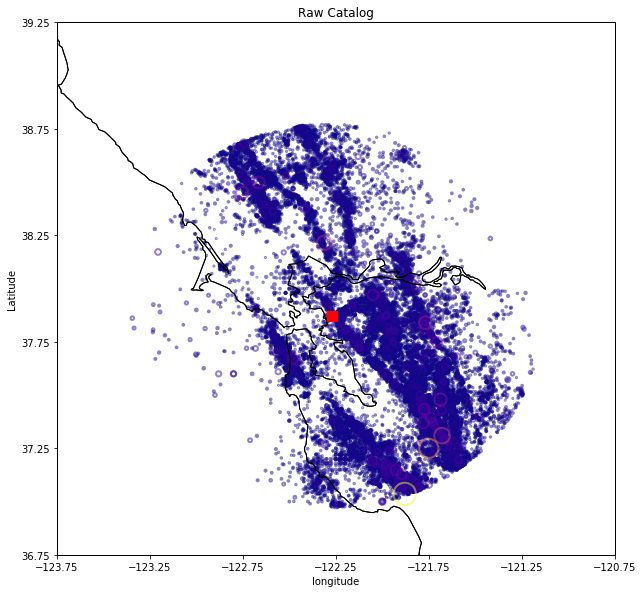

In [248]:
#Make a Map

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)
ydim=10      #height of plot
xdim=ydim*(haversine_np(lon0,lat0,lon1,lat0)/haversine_np(lon0,lat0,lon0,lat1)) #scale width

###
plt.figure(figsize=(ydim,xdim))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='longitude', ylabel='Latitude',
       title='Raw Catalog')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES,alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES.with_scale('10m'))

x=lon
y=lat
z=mag

#Sort Descending to plot largest events on top
indx=np.argsort(z)   #determine sort index
x=x[indx]            #apply sort index
y=y[indx]
z=np.exp(z[indx])    #exponent to scale size
c = plt.cm.plasma(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors='none', edgecolors=c, marker='o', linewidth=2, alpha=0.5)
plt.plot(-122.2727,37.8716,'rs',markersize=10)

#Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig('hw1_ex2_seismap_raw.pdf')
plt.savefig('hw1_ex2_seismap_raw.png')

plt.show()

# Exercise 2: Compute the Gutenberg-Richter statitistics

Follow the steps below to compute the Gutenberg Richter statistics for the raw catalog.

1) First, define a range of magnitudes to bin the data. You can use a range of magnitude, m from 0.0 to 6.9 in increments of 0.1 magnitude unit. 


In [249]:
#Determine and plot the Initial Gutenberg-Richter Distribution
m=np.arange(0.,6.9,0.1) # define a range of mag bins
N=np.zeros(len(m)) # preallocate the vector N with size=len(m)

2) Next count the number of events above a given magnitude. That is count the number of events above and equal to magnitude 0.0, then above and equal to 0.1, and so forth all the way to the maximum magnitude. You can do this by placing the code for vectorized counting of array elements passing a logical test (numpy.count_nonzero()) inside a for loop over the incremental magnitudes, m.

3) We are interested in the annual rate of the events so you will need to divide by the total number of years the catalog spans.

4) Take the log base 10 (numpy.log10) of the annual number of earthquakes for each magnitude bin. Note you can place all of the operations in (2), (3) and (4) in a single code line inside the for loop.

In [250]:
numyr=(max(days)-min(days))/365
for i in range(0,len(m),1):
    N[i]=np.log10(np.count_nonzero(mag >= m[i])/numyr) # N is defined per year, so normalize bin count by numyr

Make a plot of the distribution.

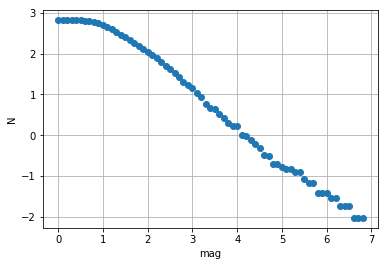

In [251]:
plt.figure()
plt.plot(m,N,'o')
plt.xlabel('mag')
plt.ylabel('N')
plt.grid()

Now, fit the Gutenberg Richter relationship $log_{10}(N(m))$=A+Bm to the data. In other words invert the data to find the applied model parameters. We will walk through the steps of this inversion:

1) First, create a matrix, A, which has one column of 1's and a second column of the magnitude bins, m. 

$$
A=\begin{pmatrix}
1 &m_0\\
1 &m_1\\
1 &m_2\\
. &.\\
. &.\\
. &.\\
1 &m_n\\
\end{pmatrix}
$$

2) We also need a single column data matrix, D, which has the $log_{10}(N(m))$ values. Note that we already defined this vector above.

$$
D=\begin{pmatrix}
log_{10}(N(m_0))\\
log_{10}(N(m_1))\\
log_{10}(N(m_2))\\
.\\
.\\
.\\
log_{10}(N(m_n))\\
\end{pmatrix}
$$

In [252]:
tmp=np.ones(len(N))        # column of 1's
A=np.column_stack((tmp,m)) # matrix A

3) Next, compute the $A^{T}A$ matrix (A-transpose times A)  using numpy functions

In [253]:
ATA=np.dot(np.transpose(A),A)

4) Next, compute the $A^{T}D$ (A-transpose times D)

In [254]:
ATD=np.dot(np.transpose(A),N) # Recall that we have already defined the D-matrix above as "N"

5) Finally, solve the inverse problem. Invert the equation $(A^{T}A)x=A^{T}D$ using the numpy linear algebra solver (numpy.linalg.solv()). The result, x, will have be a vector of the Gutenberg-Richter coefficients, in which the A-value is x[0] and the B-value is x[1]. The values you should get are A=3.418 and B=-0.809.

In [255]:
soln=np.linalg.solve(ATA,ATD) # solve the linear inverse problem
print(f'A-value={soln[0]:.3f}, B-value={soln[1]:.3f}')

A-value=3.418, B-value=-0.809


To visualize the fit to the distribution, we would like to make a plot showing the magnitude distribution as plotted above, log10(N) vs m, with the best fit line that we just found the coefficients for. 

The following figure is an example of what you should get.
<img src="./example_grfit2.png">

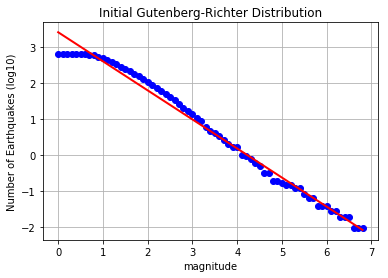

A_value= 3.418 B_value=-0.809


In [256]:
# Solution
x=m
y=np.dot(A,soln)

fig, ax = plt.subplots()
ax.plot(m, N,'bo',x,y,'r-',linewidth=2)
ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Initial Gutenberg-Richter Distribution')
ax.grid()

fig.savefig("hw1_ex3_figure2.png")
plt.show()

print(f'A_value= {soln[0]:.3f} B_value={soln[1]:.3f}')

Next, compute the uncertainties of the model (best-fit line). The following steps outline how to compute 95% confidence intervals for the model using the numpy and scipy packages in Python.

1) df=(length_of_data) - (number_of_model_parameters) #degree of freedom

In [257]:
length_of_data = len(N)
number_of_model_parameters = 2

df=(length_of_data) - (number_of_model_parameters)

2) e=data-(model predictions) #prediction error

In [258]:
e=N-y

3) variance=np.sum(e*e)/df

In [259]:
var=np.sum(e*e)/df

4) se_y=np.sqrt(var)                       #standard error of the estimate

In [260]:
se_y=np.sqrt(var)

5) sdev=np.sqrt(var)                       #standard deviation

In [261]:
sdev=np.sqrt(var)

6) t=stats.t.ppf(1-0.05/2,degfree)             #two-sided students t-distribution

In [262]:
t=stats.t.ppf(1-0.05/2,df)

7) lower95=np.exp(np.log(modeled_pga)-t*se_y)

8) upper95=np.exp(np.log(modeled_pga)+t*se_y)

In [263]:
lower95=y-t*se_y
upper95=y+t*se_y

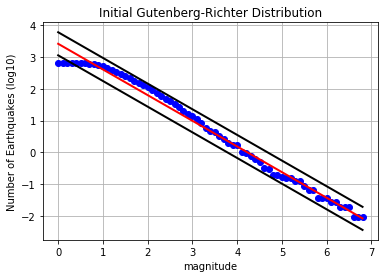

In [264]:
fig, ax = plt.subplots()
ax.plot(m, N,'bo',x,y,'r-',linewidth=2)
ax.plot(x,upper95,'k-',linewidth=2)
ax.plot(x,lower95,'k-',linewidth=2)

ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Initial Gutenberg-Richter Distribution')
ax.grid()

plt.savefig("hw1_ex3_figure2_withErrorBounds.png")
plt.show()

9) standard error of slope

In [265]:
se_b=sdev/np.sqrt(np.sum((x-np.mean(x))**2))                      #standard error slope
print(se_b)

0.011003789605884244


10) standard error of intercept (9 and 10 will be important for incorporating Gutenberg Richter uncertainty in PSHA (a future homework)

In [266]:
se_a=sdev*np.sqrt(1/len(x) + np.mean(x)**2/np.sum((x-np.mean(x))**2)) #standard error of intercept
print(se_a)

0.04335921319038039


### Questions

1. How well does the Gutenberg-Richter model fit the data?
2. Where does the fit begin to breakdown and why?
3. Based on your Gutenberg-Richter coefficients what is the annual rates of a M4 earthquake? For a M7 earthquake?
4. On average how many years are there between M7 earthquakes based on this catalog.
5. How many M7 earthquakes are in the catalog?
6. What is your assessment of the quality or suitability of the forecast of average M7 occurrence?

# Exercise 3: Declustering

In the above analysis mainshocks (primary events) and aftershocks are mixed together. The results were pretty good, however a correct implementation of Gutenberg-Richter considers only the primary events, and therefore a catalog with aftershocks removed is needed. The process to remove aftershocks is called declustering.

In this exercise you will decluster the catalog, evaluating several different published methods of declustering (see following block), and compute the Gutenberg-Richter coefficients for each declustered catalog to examine the variablity in the estimated parameters due to the different declustering algorithms.

<img src="files/example_grfit2.png">

### Declustering Algorithm

The analysis that was just performed was for the raw catalog, which means that it includes all events. However Gutenberg-Richter is really interested in the occurrence of primary "main shock" events, and therefore it is necessary to decluster the catalog to obtain an unbiased estimate of the G-N coefficients. Declustering here means remove the aftershocks from the catalog. This is done using an algorithm that relates the "expected" time and distance range of aftershocks from a given mainshock. Large mainshocks will result in aftershock populations that, statistically speaking, have a greater likelihood to occur over longer time periods and greater mainshock-aftershock distances compared with smaller mainshock-aftershock series. 

The code block below defines a declustering algorithm. The 'Dtest' and 'Ttest' are magnitude dependent distance and time metrics. If a given event falls within the maximal values defined by Dtest and Ttest for a given earthquake it is then removed from the catalog. The remaining catalog is then comprised of primary events, and can be used to estimate more accurate Gutenberg-Richter statistics. 

Furthermore, we can study the aftershock events that the algorithm removed for a given earthquake in the context of the Omori Law statistics.

The relationships to compute the distance and time windows to identify aftershocks (the Dtest and Ttest functions above) were proposed by Knopoff and Gardner (1972). There are other relationships.

Compare the event reduction rate (final number divided by the initial number of events) for the different proposed distance and time windows on page 10 of Stiphout et al. (2012). You can do this by adding a logical (if statement) tree to enable switching between different definitions of Dtest and Ttest in the 'Decluster the catalog' code block below.

The alternative functions from vanStiphout et al. (2012) are as follows, where M is magnitude, d is the Dtest in km, and t is Ttest in days.

<img src="./vanStiphout.png">

In [267]:
#Decluster the Catalog, note: This cell may take a few minutes to complete
cnt=0
save=np.zeros((1,10000000),dtype=int)

for i in range(0,nevt,1):
    
    #You can add logical if-statements to incorporate different definitions of Dtest and Ttest here see Exercise 3
    Dtest=np.power(10,0.1238*mag[i]+0.983)
    
    if mag[i] >= 6.5:
        Ttest=np.power(10,0.032*mag[i]+2.7389)
    else:
        Ttest=np.power(10,0.5409*mag[i]-0.547)
    
    a=days[i+1:nevt]-days[i]
    m=mag[i+1:nevt]
    b=haversine_np(lon[i],lat[i],lon[i+1:nevt],lat[i+1:nevt])
    
    icnt=np.count_nonzero(a <= Ttest)
    if icnt > 0:
        itime=np.array(np.nonzero(a <= Ttest)) + (i+1)
        for j in range(0,icnt,1):             
            if b[j] <= Dtest and m[j] < mag[i]:
                save[0][cnt]=itime[0][j]
                cnt += 1

                
save=np.delete(np.unique(save),0)   #Note this is an array of indexes that will be used to delete events flagged 
                                    #as aftershocks    

In [268]:
# Filter or slice out the declustered and aftershock dataframe catalogs from the 
# original dataframe catalog "data" using "save" above.
data_aftershocks = data.iloc[save]
data_declustered = data.iloc[~data.index.isin(save)]

# This condition should print out "True" if the catalogs were separated correctly
len(data) == len(data_aftershocks) + len(data_declustered)

True

### Questions

1. How many events were removed from the catalog?

2. Make a plot showing a map of the declustered catalog and compare the spatial distribution of earthquakes between the raw and declustered catalogs.

3. For the two other methods of declusting how many events were removed from the catalog?

### Re-compute the Gutenberg-Richter statistics as above for the declustered catalog

In [269]:
dd=np.array(data_declustered)    # load the declustered dataframe into numpy as an array      
dyear=dd[:,0].astype(int)        # define variables from the array
dmonth=dd[:,1].astype(int)
dday=dd[:,2].astype(int)
dhour=dd[:,3].astype(int)
dmn=dd[:,4].astype(int)
dsec=dd[:,5].astype(int)
dlat=dd[:,6]
dlon=dd[:,7]
dmag=dd[:,8]

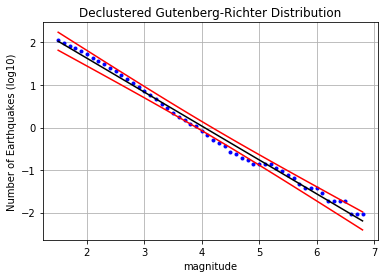

A_value= 3.221 B_value=-0.797
95%intercept= 0.082 95%slope=0.018


In [270]:
#Determine and plot the Gutenberg-Richter Distribution for De-clustered data
#You may want to adjust the magnitude range of the analysis to focus on where the catalog is complete
m=np.arange(1.5,6.9,0.1)
N=np.zeros(len(m))

for i in range(0,len(m),1):
    N[i]=np.log10(np.count_nonzero(dmag >= m[i])/numyr)

#Invert for A and B values
tmp=np.ones(len(N))
A=np.column_stack((tmp,m))
ATA=np.dot(np.transpose(A),A)
ATD=np.dot(np.transpose(A),N)
soln=np.linalg.solve(ATA,ATD)
x=m
y=np.dot(A,soln)

#Compute the uncertainty in Gutenberg-Richter Parameters

df=len(N) - 2                 #degree of freedom
e=N-y                         #prediction error
var=np.sum(e**2)/df
se_y=np.sqrt(var)             #standard error of the estimate
sdev=np.sqrt(var)             #standard deviation

#Calculate 95% confidence bounds
t=stats.t.ppf(1-0.05/2,df)    #two-sided students t-distribution
tmp=np.sqrt(1/len(x)+((x-np.mean(x))**2)/np.sum((x-np.mean(x))**2))
tmp=tmp/max(tmp)
lower95=y-t*se_y*tmp
upper95=y+t*se_y*tmp
se_b=sdev/np.sqrt(np.sum((x-np.mean(x))**2))                      #standard error slope
se_a=sdev*np.sqrt(1/len(x) + np.mean(x)**2/np.sum((x-np.mean(x))**2)) #standard error of intercept
a95=se_a*t
b95=se_b*t

#Now Plot
fig, ax = plt.subplots()
ax.plot(m, N,'b.',x,y,'k-',x,lower95,'r-',x,upper95,'r-')
ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Declustered Gutenberg-Richter Distribution')
ax.grid()

fig.savefig("hw1_ex4_figure4.png")
plt.show()

print(f'A_value= {soln[0]:.3f} B_value={soln[1]:.3f}')
print(f'95%intercept= {a95:.3f} 95%slope={b95:.3f}')

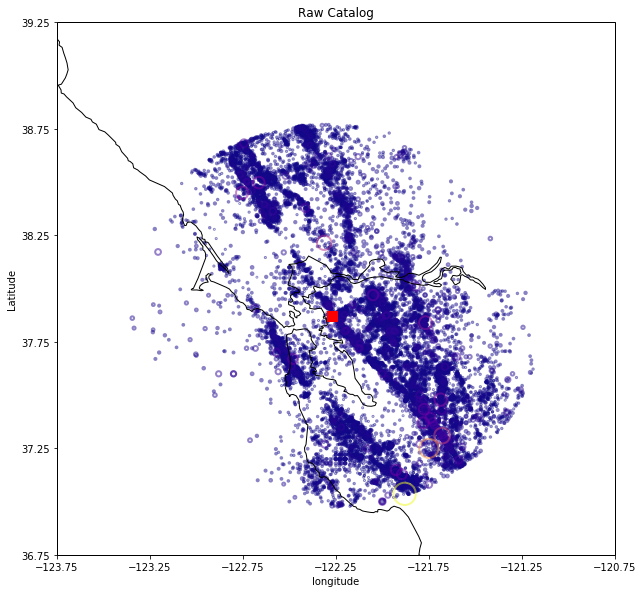

In [271]:
#Make a Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)
ydim=10      #height of plot
xdim=ydim*(haversine_np(lon0,lat0,lon1,lat0)/haversine_np(lon0,lat0,lon0,lat1)) #scale width
###
###
plt.figure(figsize=(ydim,xdim))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='longitude', ylabel='Latitude',
       title='Raw Catalog')

#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
#ax.add_feature(cfeature.RIVERS)
#ax.add_feature(cfeature.STATES.with_scale('10m'))

#x=lon
#y=lat
#z=mag
x=np.delete(lon,save)
y=np.delete(lat,save)
z=np.delete(mag,save)
#Sort Descending
indx=np.argsort(z)   #determine sort index
x=x[indx]            #apply sort index
y=y[indx]
z=np.exp(z[indx])    #exponent to scale size
#plt.scatter(x, y, s=z, c=z, marker='o', linewidth=1)
c = plt.cm.plasma(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors='none', edgecolors=c, marker='o', linewidth=2, alpha=0.5)
plt.plot(-122.2727,37.8716,'rs',markersize=10)

#Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig('hw1_ex4_seismap_declust.pdf')
plt.savefig('hw1_ex4_seismap_declust.png')

plt.show()

### Questions

1) Compare the Gutenberg-Richter A and B coefficients for the three versions of the declustered catalog.

2) What is the annual rate of occurrence of M4 earthquakes for each of the declustered catalogs?

3) What is the average M7 return period (inverse of annual occurrence of M7 events) for the each of the declustered catalogs?

4) Compare your estimated values with what has been presented in the USGS Earthquake Hazard Assessments of the return period for Hayward fault earthquakes.

# Exercise 4: Omori Law for Loma Prieta M6.9 Event

Here we will use the declustering algorithm to identify aftershocks of the October 18 1989 at 04:15am (October 17 at 5:15pm PDT) the M6.9 Loma Prieta earthquake occurred in the Santa Cruz mountains approximately 80 km southwest of the Berkeley Campus. This wiki has some background information for the earthquake: https://en.wikipedia.org/wiki/1989_Loma_Prieta_earthquake

### Load the Earthquake Catalog

Load the .csv data file of all the earthquakes 1900 - 2018 in the ANSS (Advanced National Seismic System) catalog from 100 km around Berkeley.

In [57]:
# read back in the raw data

# This catalog is a M0+ search centered at Berkeley radius=100km. 
# A big enough radius to include Loma Prieta but exclude Geysers.
data=pd.read_csv('anss_catalog_1900to2018all.txt', sep=' ', delimiter=None, header=None,
                 names = ['Year','Month','Day','Hour','Min','Sec','Lat','Lon','Mag'])

### Select earthquakes related to the Loma Prieta Earthquake

Use Boolean indexing to select events from the full catalog from between October 18, 1989 (date of mainshock) and December 18, 1989 (3-months following).

In [58]:
EQ_1989 = data[(data.Year>=1989) & (data.Year<1990)]          #get one year of data
fall_eq = EQ_1989[(EQ_1989.Month>9) & (EQ_1989.Month<=12)]    #collect months of Oct, Nov and Dec
LP_eq = fall_eq[(~((fall_eq.Month==10) & (fall_eq.Day<18)))]  #negate events before day (assumes first month is 10)
LP_eq = LP_eq[(~((LP_eq.Month==12) & (LP_eq.Day>18)))]        #negate events after day (assumes last month is 12)

Create data arrays for 3-month period beginning with Loma Prieta Earthquake

In [59]:
#LP_eq=EQ_1989             #override for plotting entire year catalog
year=LP_eq.Year.values
month=LP_eq.Month.values
day=LP_eq.Day.values
hour=LP_eq.Hour.values
mn=LP_eq.Min.values
sec=LP_eq.Sec.values
lat=LP_eq.Lat.values
lon=LP_eq.Lon.values
mag=LP_eq.Mag.values
nevt=len(year)        #number of events 

### Plot the Loma Preita time series

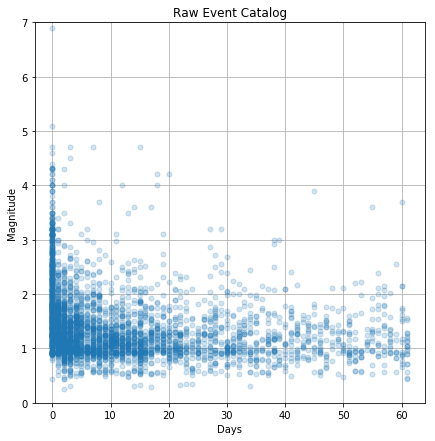

Number=3692 MinMag=0.25 MaxMag=6.90


In [60]:
#Need to determine the number of days from the first event
days=np.zeros(nevt) # initialize the size of the array days
for i in range(0,nevt,1): # Loop over events to count days since event
    d0 = datetime.date(year[0], month[0], day[0])
    d1 = datetime.date(year[i], month[i], day[i])
    delta = d1 - d0
    days[i]=delta.days # fill days in with the number of days since the first event

# plot magnitude vs. time
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(days, mag,'o',alpha=0.2,markersize=5)
ax.set(xlabel='Days', ylabel='Magnitude',
       title='Raw Event Catalog')
ax.grid()
ax.set_ylim([0,7])
fig.savefig("hw1_ex4_ts_raw.png")
plt.show()

print(f'Number={nevt:d} MinMag={min(mag):.2f} MaxMag={max(mag):.2f}')

### Plot the Loma Preita Earthquake Catalog in map view

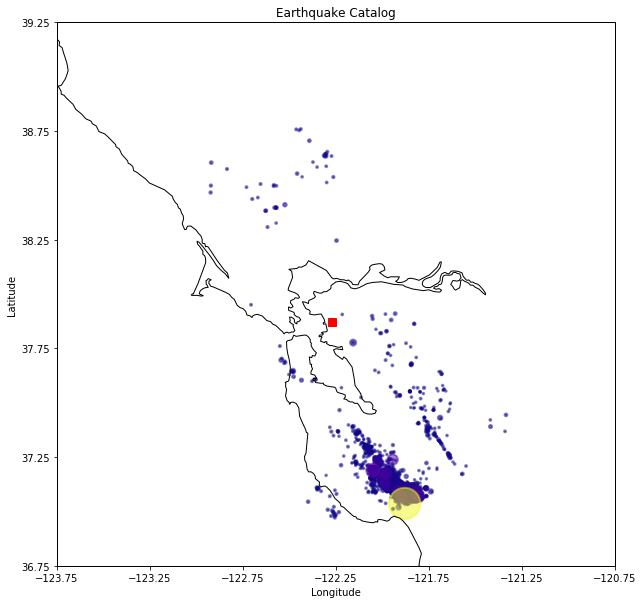

In [61]:
#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=1)
ax.set_aspect('auto')
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='Longitude', ylabel='Latitude',
       title='Earthquake Catalog')

x=lon
y=lat
z=mag

#Sort Descending to plot largest events on top
indx=np.argsort(z)   #determine sort index
x=x[indx]            #apply sort index
y=y[indx]
z=np.exp(z[indx])    #exponent to scale marker size

c = plt.cm.plasma(z/max(z)) # colormap scales with magnitude
plt.scatter(x, y, s=(z), facecolors=c, alpha=0.5, edgecolors=c, marker='o', linewidth=2) # plot circles on EQs
plt.plot(-122.2727,37.8716,'rs',markersize=8)  # plot red square on Berkeley

plt.savefig("hw1_ex4_map_raw.png")

plt.show()

### Decluster the Raw Catalog for the Loma Prieta time period

We use the same decluster algorithm previously to identify aftershocks and remove them from the 30-day Loma Preita catalog.

In [62]:
#Decluster the Catalog  Note: This cell may take a few minute to complete

cnt=0 # initialize a counting variable
save=np.zeros((1,10000000),dtype=int) # initialize a counting variable

for i in range(0,nevt,1):   # step through EQ catalog
    
    # logical if statements to incorporate definitions of Dtest and Ttest aftershock window bounds
    Dtest=np.exp(1.77+(0.037+1.02*mag[i])**2)   # distance bounds
    if mag[i] >= 6.5:
        Ttest=abs(np.exp(-3.95+(0.62+17.32*mag[i])**2))  # aftershock time bounds for M >= 6.5
    else:
        Ttest=np.power(10,0.024*mag[i]+2.8)  # aftershock time bounds for M < 6.5
    
    a=days[i+1:nevt]-days[i]    # time interval in days to subsequent earthquakes in catalog
    m=mag[i+1:nevt]   # magnitudes of subsequent earthquakes in catalog
    b=haversine_np(lon[i],lat[i],lon[i+1:nevt],lat[i+1:nevt]) # distance in km to subsequent EQs in catalog
    
    icnt=np.count_nonzero(a <= Ttest)   # counts the number of potential aftershocks, 
                                        # the number of intervals <= Ttest bound
    if icnt > 0:  # if there are potential aftershocks
        itime=np.array(np.nonzero(a <= Ttest)) + (i+1) # indices of potential aftershocks <= Ttest bound
        for j in range(0,icnt,1):   # loops over the aftershocks         
            if b[j] <= Dtest and m[j] < mag[i]: # test if the event is inside the distance window 
                                                # and that the event is smaller than the current main EQ
                save[0][cnt]=itime[0][j]  # index value of the aftershock
                cnt += 1 # increment the counting variable

                
after=np.delete(np.unique(save),0)   # This is an array of indexes that will be used to delete events flagged 
                                      # as aftershocks    

Create two sets of arrays, one for the declustered catalog and one for the aftershock catalog. Use `np.delete()` to delete the aftershock events for the declustered catalog, and use `after` to select the aftershock events for the aftershock calalog. 

In [63]:
# delete the aftershock events
declustered_days=np.delete(days,after)  #The aftershocks are deleted from the days array 
declustered_mag=np.delete(mag,after)    #The aftershocks are deleted from the mag array 
declustered_lon=np.delete(lon,after)    #The aftershocks are deleted from the lon array 
declustered_lat=np.delete(lat,after)    #The aftershocks are deleted from the lat array 
n=len(declustered_days)

In [64]:
# select the aftershock events
aftershock_days=days[after]  #The aftershocks are selected from the days array 
aftershock_mag=mag[after]    #The aftershocks are selected from the mag array 
aftershock_lon=lon[after]    #The aftershocks are selected from the lon array 
aftershock_lat=lat[after]    #The aftershocks are selected from the lat array 
n2=len(aftershock_days)

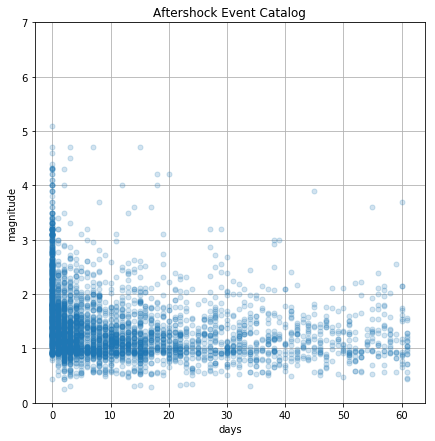

Number=3691 MinMag=0.25 MaxMag=5.10


In [65]:
#Plot Aftershock Catalog in time series
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(aftershock_days, aftershock_mag,'o',alpha=0.2,markersize=5)
ax.set(xlabel='days', ylabel='magnitude',
       title='Aftershock Event Catalog')
ax.grid()
ax.set_ylim([0,7])
fig.savefig("hw1_ex4_ts_aftershockOnly.png")
plt.show()

print(f'Number={n2:d} MinMag={min(aftershock_mag):.2f} MaxMag={max(aftershock_mag):.2f}')

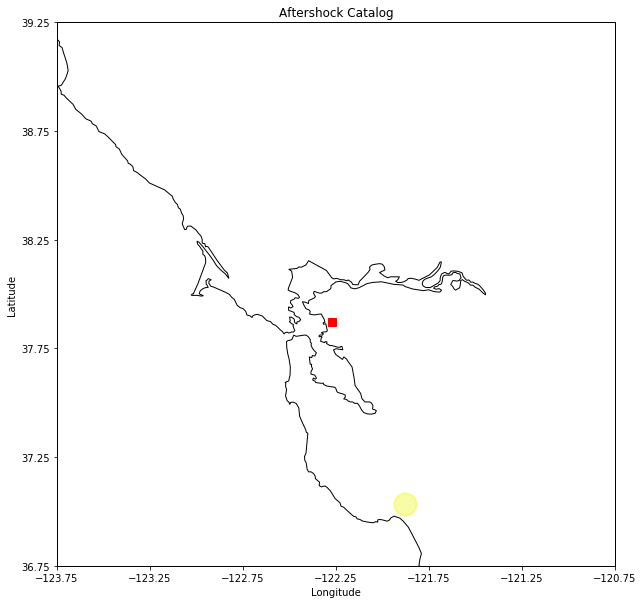

In [66]:
#Make a Map of the declustered events

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='Longitude', ylabel='Latitude',
       title='Aftershock Catalog')


x=declustered_lon
y=declustered_lat
z=declustered_mag

#Sort Descending to plot largest events on top
indx=np.argsort(z)   #determine sort index
x=x[indx]            #apply sort index
y=y[indx]
z=np.exp(z[indx])    #exponent to scale size

c = plt.cm.plasma(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors=c, alpha=0.4, edgecolors=c, marker='o', linewidth=2)
plt.plot(-122.2727,37.8716,'rs',markersize=8)

plt.savefig("hw1_ex4_map_mainshockOnly.png")


plt.show()

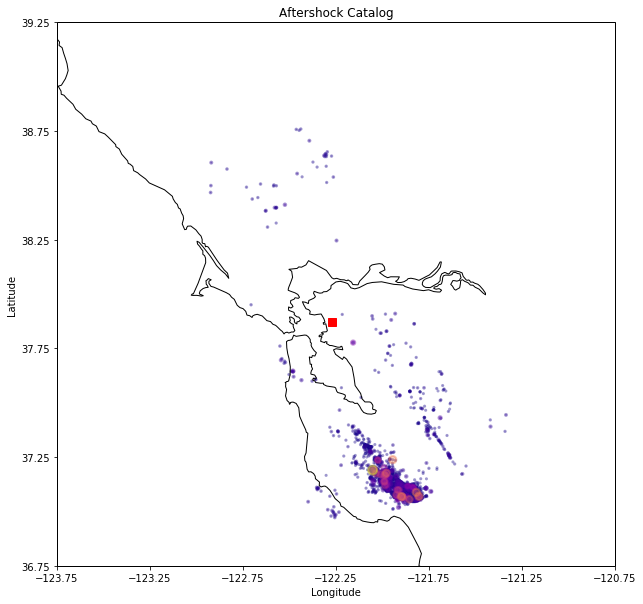

In [67]:
#Make a Map of Aftershock events

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='Longitude', ylabel='Latitude',
       title='Aftershock Catalog')


x=aftershock_lon
y=aftershock_lat
z=aftershock_mag

#Sort Descending to plot largest events on top
indx=np.argsort(z)   #determine sort index
x=x[indx]            #apply sort index
y=y[indx]
z=np.exp(z[indx])    #exponent to scale size

c = plt.cm.plasma(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors=c, alpha=0.4, edgecolors=c, marker='o', linewidth=2)
plt.plot(-122.2727,37.8716,'rs',markersize=8)

plt.savefig("hw1_ex4_map_aftershockOnly.png")

plt.show()

### Questions
1. How many declustered events and aftershock events were there?

2. What faults were active?

3. What could cause aftershocks to occur on faults other than the mainshock fault?

4. Here we used a 3-month period beginning at the Loma Prieta Earthquake. Examine the results taking a 6-month period beginning 3 months before the Loma Prieta earthquake. How does the distribution of earthquakes differ for the two time periods.

### Omori statistics

To compute the Omori statistics we want to bin the log10 of the number of aftershocks each day following the mainshock and fit a power law equation such as:

\begin{matrix}
N=\frac{A}{(t+\epsilon)^P}, 
\end{matrix}

where t is time in days, N is the number of earthquakes in the 24 hour period, and $\epsilon$ is a small number (fraction of a day) to avoid the singularity at zero time. A and P are the coeffients that we want to find through regression. This power law equation can be linearized by simply taking the log10 of both sides giving:

\begin{matrix}
log_{10}(N)=a - P*log_{10}(t+\epsilon)
\end{matrix}

Note: We will use both the Gutenberg-Richter and the Omori Law statistics computed in Homework 1 in Homework 2 where we will examine the probability of earthquake occurrence and aftershock occurrence following a given mainshock.



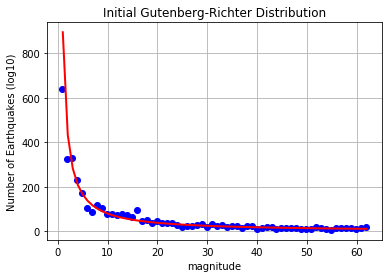

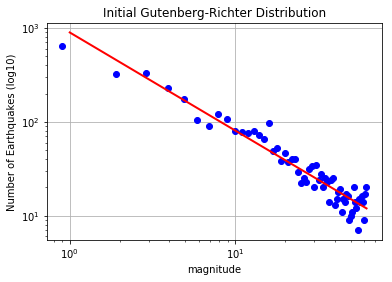

A_value= 2.952 P_value=-1.046


In [68]:
#find the number of aftershocks in each day
epsilon=0.1
maxdays=np.int(np.max(aftershock_days))
t=np.arange(1,maxdays+2,1)
logt=np.log10(t)
N=np.zeros(maxdays+1)

for i in range(0,maxdays+1,1):
    N[i]=np.count_nonzero(aftershock_days == i)
logN=np.log10(N)

#Invert for A and B values
tmp=np.ones(len(logN))
A=np.column_stack((tmp,logt))
ATA=np.dot(np.transpose(A),A)
ATD=np.dot(np.transpose(A),logN)
soln=np.linalg.solve(ATA,ATD)
x=t
y=10**np.dot(A,soln)

#Now Plot
fig, ax = plt.subplots()
ax.plot(t-epsilon, N,'bo',x,y,'r-',linewidth=2)
ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Initial Gutenberg-Richter Distribution')
ax.grid()
plt.savefig("hw1_ex4_GNstats_linlin.png")
plt.show()

#Now Plot
fig, ax = plt.subplots()
ax.loglog(t-epsilon, N,'bo',x,y,'r-',linewidth=2)
ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Initial Gutenberg-Richter Distribution')
ax.grid()
plt.savefig("hw1_ex4_GNstats_loglog.png")
plt.show()

print(f'A_value= {soln[0]:.3f} P_value={soln[1]:.3f}')

### Questions

1. How does the estimated P-value compare to values reported in Lay and Wallace?

2. Is the aftershock more or less productive than average?

3. What is the number of earthquakes per day in the region for the period leading up to the Loma Prieta earthquake?

4. How long after the earthquake would does the applied Omori Law predict the that the aftershock rate falls to the pre-event rate of earthquakes?


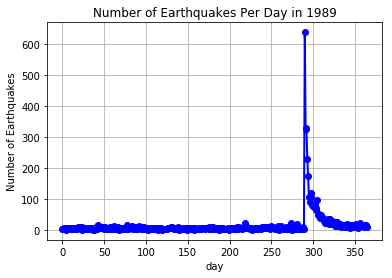

In [69]:
#plot of the number of earthquakes per day for 1989

#  create data arrays for the entirety of 1989
year=EQ_1989.Year.values
month=EQ_1989.Month.values
day=EQ_1989.Day.values
nevt=len(year)        #number of events 

#Determine the number of days from the first event
days=np.zeros(nevt) # initialize the size of the array days

for i in range(0,nevt,1):
    d0 = datetime.date(year[0], month[0], day[0])
    d1 = datetime.date(year[i], month[i], day[i])
    delta = d1 - d0
    days[i]=delta.days # fill days in with the number of days since the first event
    
maxdays=np.int(np.max(days))
NN=np.zeros(maxdays+1)
t=np.arange(0,maxdays+1,1)
for i in range(0,maxdays+1,1):
    NN[i]=np.count_nonzero(days == i)

#Now Plot
fig, ax = plt.subplots()
ax.plot(t, NN,'bo-',linewidth=2)
ax.set(xlabel='day', ylabel='Number of Earthquakes',
       title='Number of Earthquakes Per Day in 1989')
ax.grid()
plt.savefig("hw1_ex4_omori.png")
plt.show()